Import libraries

In [3]:
import torch
from diffusers import AutoencoderKL
from PIL import Image
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
import requests
from io import BytesIO

Download the Latent Diffusion VAE from hugging face.

In [4]:
# Load VAE model
vae = AutoencoderKL.from_pretrained("stabilityai/sd-vae-ft-mse")
vae.eval()

AutoencoderKL(
  (encoder): Encoder(
    (conv_in): Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (down_blocks): ModuleList(
      (0): DownEncoderBlock2D(
        (resnets): ModuleList(
          (0-1): 2 x ResnetBlock2D(
            (norm1): GroupNorm(32, 128, eps=1e-06, affine=True)
            (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (norm2): GroupNorm(32, 128, eps=1e-06, affine=True)
            (dropout): Dropout(p=0.0, inplace=False)
            (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (nonlinearity): SiLU()
          )
        )
        (downsamplers): ModuleList(
          (0): Downsample2D(
            (conv): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2))
          )
        )
      )
      (1): DownEncoderBlock2D(
        (resnets): ModuleList(
          (0): ResnetBlock2D(
            (norm1): GroupNorm(32, 128, eps=1e-06, affine=True)
            (c

Download and preprocess image.

In [5]:
# Download and load image from URL
url = "https://www.cs.toronto.edu/~lindell/teaching/420/slides/celebahq/43.jpg"
response = requests.get(url)
img = Image.open(BytesIO(response.content)).convert("RGB")

# Transform to tensor
transform = transforms.Compose([
    transforms.Resize((512, 512)),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])  # Normalize to [-1, 1]
])

img_tensor = transform(img).unsqueeze(0)  # Add batch dimension


Run the image through the VAE

In [6]:
# Encode and decode
with torch.no_grad():
    latent = vae.encode(img_tensor).latent_dist.sample()
    reconstructed = vae.decode(latent).sample

Display the images

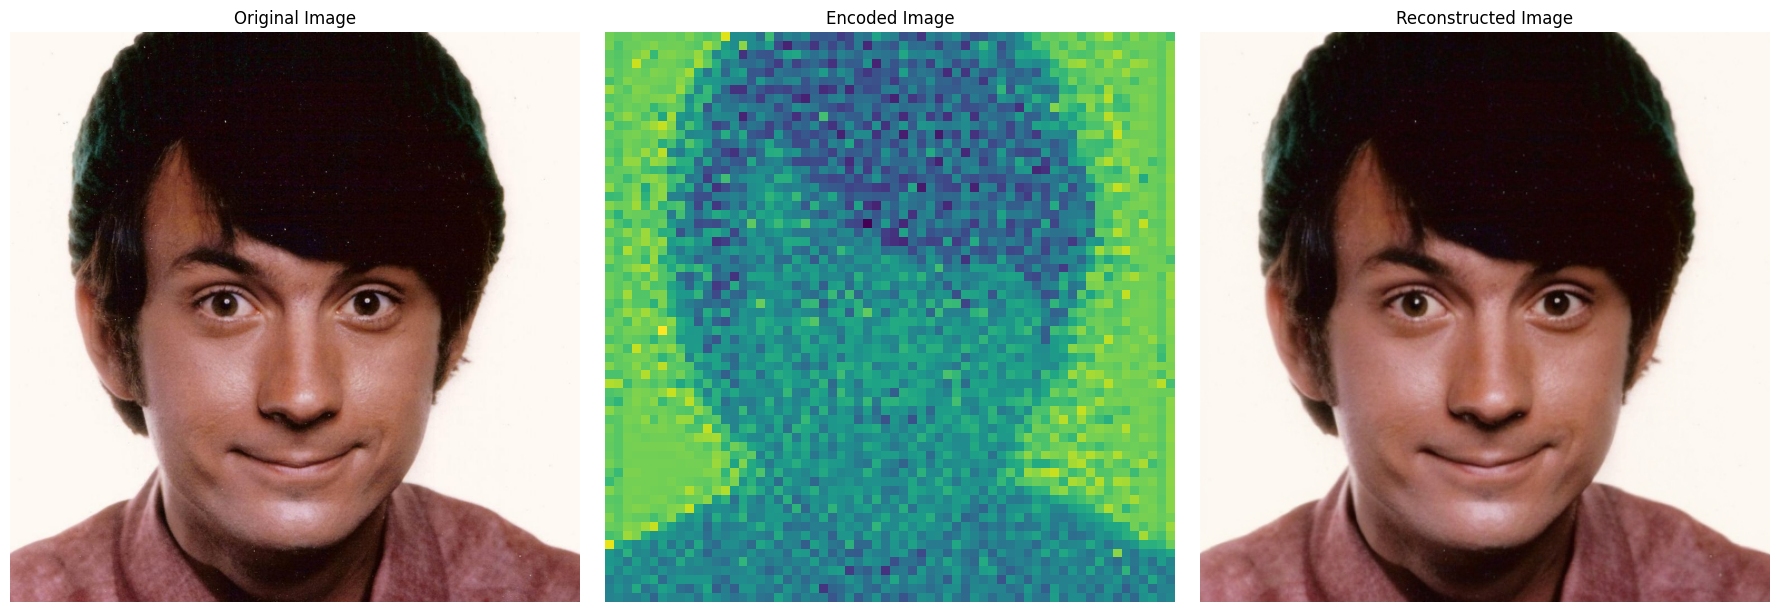

Original shape: torch.Size([1, 3, 512, 512])
Latent shape: torch.Size([1, 4, 64, 64])
Reconstructed shape: torch.Size([1, 3, 512, 512])


In [8]:
# Convert back to displayable format
def tensor_to_pil(tensor):
    tensor = (tensor + 1) / 2  # Denormalize from [-1,1] to [0,1]
    tensor = torch.clamp(tensor, 0, 1)
    return transforms.ToPILImage()(tensor.squeeze(0))

reconstructed_img = tensor_to_pil(reconstructed)

# Convert latent to displayable format (normalize for visualization)
latent_vis = (latent.squeeze(0).mean(dim=0) - latent.min()) / (latent.max() - latent.min())

# Plot comparison
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))

ax1.imshow(img)
ax1.set_title("Original Image")
ax1.axis('off')

ax2.imshow(latent_vis.cpu(), cmap='viridis')
ax2.set_title("Encoded Image")
ax2.axis('off')

ax3.imshow(reconstructed_img)
ax3.set_title("Reconstructed Image")
ax3.axis('off')

plt.tight_layout()
plt.show()

print(f"Original shape: {img_tensor.shape}")
print(f"Latent shape: {latent.shape}")
print(f"Reconstructed shape: {reconstructed.shape}")